## Load data

In [245]:
import warnings
warnings.filterwarnings('ignore')

In [162]:

import pandas as pd
import numpy as np

#lost code for this ds, but thankfully I had the csv saved. this is the same as the clean_speeddating_with_na.csv ds but I removed all the binned columns and the has_null column
df = pd.read_csv("clean_speeddating_removed_na_and_bins.csv", low_memory=False)
df = df.applymap(lambda x: np.nan if x == '?' else x)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#also get rid of decision and decision_o and like because that would give it away. and get rid of the first two unnamed columns (not sure where they came from?)
#df = df.drop(['decision', 'decision_o', 'like'], axis=1)
df.drop(df.columns[[0]], axis=1, inplace=True)
#df.to_csv('clean_speeddating_with_na_no_bins2.csv')


In [163]:
df.shape

(4862, 62)

## Feature selection using kbest

#### first pre process

In [166]:
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#from mlxtend.preprocessing import DenseTransformer
from sklearn.preprocessing import StandardScaler

##first have to preprocess

#make an encoder for all the categorical columns
encoder = OneHotEncoder(handle_unknown='infrequent_if_exist')
categorical_cols = ["gender", "race", "race_o", "field"]

#standard scale all numeric columns since some are on scale of 0-100 and some from 1-10 and some are binary (like same_race)
std_scaler = StandardScaler()
all_cols = df.columns.tolist()
numeric_cols = [col for col in all_cols if col not in categorical_cols]
numeric_cols.remove('match')

#now use a column transformer to do both pre processors on their separate columns
transformer = ColumnTransformer( 
        [('categories', encoder, categorical_cols),
        ('numeric', std_scaler, numeric_cols)],
        sparse_threshold=0,
        remainder='drop', verbose_feature_names_out=False)

#### then split ds

## Now to balance the training set
1.  separate out the matches and non-matches
2.  randomly sample from the non-matches (using the number of matches)
3.  Concatenate the new non-match set with the match set and remove the dependent variable

In [225]:
from sklearn.model_selection import train_test_split


def split_and_balance(data):
    X_train, X_test, y_train, y_test = train_test_split(data, data['match'], stratify = data['match']) 
    X_train_match = X_train[X_train['match'] == 1]
    X_train_no_match = X_train[X_train['match'] == 0]
    num_matches = X_train_match['match'].count()
    X_train_no_match = X_train_no_match.sample(n=num_matches)

    X_train_no_match.shape

    X_train_final = pd.concat([X_train_match, X_train_no_match])

    y_train_final = X_train_final['match']
    X_train_final = X_train_final.loc[:, X_train_final.columns != 'match']

    X_test = X_test.loc[:, X_test.columns != 'match']

    return X_train_final, y_train_final, X_test, y_test


In [226]:

X_train_final, y_train_final, X_test, y_test = split_and_balance(df)

X_train_final.shape



(1224, 61)

## We have a balanced training set.

In [227]:
counts = y_train_final.value_counts()
counts[1]/(counts[0]+counts[1])

0.5

## Our test set represents the distribution of the original data.

In [230]:
counts = y_test.value_counts()
counts[1]/(counts[0]+counts[1])

0.16776315789473684

#### then kbest

In [231]:
transformer.fit(X_train_final, y_train_final)

feature_selector = SelectKBest(k=10)

X_train_trans2 = transformer.transform(X_train_final)

X_train_trans_df2 = pd.DataFrame(X_train_trans2, columns = transformer.get_feature_names_out())

feature_selector.fit(X_train_trans_df2, y_train_final)

SelectKBest()

In [232]:
X_train_trans_df2.head()

,gender_female,gender_male,race_asian/pacific islander/asian-american,race_black/african american,race_european/caucasian-american,race_latino/hispanic american,race_other,race_o_asian/pacific islander/asian-american,race_o_black/african american,race_o_european/caucasian-american,race_o_latino/hispanic american,race_o_other,field_african-american studies/history,field_anthropology,field_anthropology/education,field_applied maths/econs,field_applied physiology & nutrition,field_architecture,field_art education,field_art history,field_art history/medicine,field_arts administration,field_bilingual education,field_biochemistry,field_biochemistry & molecular biophysics,field_biochemistry/genetics,field_biology,field_biology phd,field_biomedical engineering,field_biomedical informatics,field_biomedicine,field_biotechnology,field_business,field_business [mba],field_business administration,field_business consulting,field_business school,field_business- mba,field_business/ finance/ real estate,field_business/law,field_business; media,field_cell biology,field_chemistry,field_classics,field_climate dynamics,field_clinical psychology,field_cognitive studies in education,field_communications,field_communications in education,field_computer science,field_conservation biology,field_consulting,field_counseling psychology,field_creative writing,field_creative writing - nonfiction,field_creative writing [nonfiction],field_curriculum and teaching/giftedness,field_earth and environmental science,field_ecology,field_economics,field_economics and political science,field_economics; english,field_economics; sociology,field_education,field_education leadership - public school administration,field_education policy,field_education- literacy specialist,field_educational psychology,field_electrical engg.,field_electrical engineering,field_elementary education,field_elementary education - preservice,field_elementary/childhood education [ma],field_engineering,field_english,field_english and comp lit,field_english education,field_environmental engineering,field_epidemiology,field_film,field_finanace,field_finance,field_finance&economics,field_finance/economics,field_financial math,field_french,field_fundraising management,field_general management/finance,field_genetics,field_german literature,field_gs postbacc premed,field_gsas,field_history,field_history of religion,field_human rights,field_human rights: middle east,field_industrial engineering,field_industrial engineering/operations research,field_instructional tech & media,field_intellectual property law,field_international affairs,field_international affairs - economic development,field_international affairs - economic policy,field_international affairs and public health,field_international affairs/international finance,field_international business,field_international development,field_international educational development,field_international politics,field_international security policy - sipa,field_intrernational affairs,field_japanese literature,field_journalism,field_law,field_law and english literature [j.d./ph.d.],field_law and social work,field_law/business,field_ma science education,field_marine geophysics,field_marketing,field_master in public administration,field_masters in public administration,field_masters of industrial engineering,field_masters of social work,field_math,field_math education,field_math of finance,field_mathematical finance,field_mathematics,field_mba,field_mba - private equity / real estate,field_mba / master of international affairs [sipa],field_mba finance,field_mechanical engineering,field_medical informatics,field_medicine,field_medicine and biochemistry,field_mfa -film,field_mfa acting program,field_mfa creative writing,field_mfa writing,field_microbiology,field_modern chinese literature,field_molecular biology,field_museum anthropology,field_music education,field_neuroscience,field_nonfiction writing,field_nutrition,field_nutritiron,field_operations research,field_oper

<Axes: >

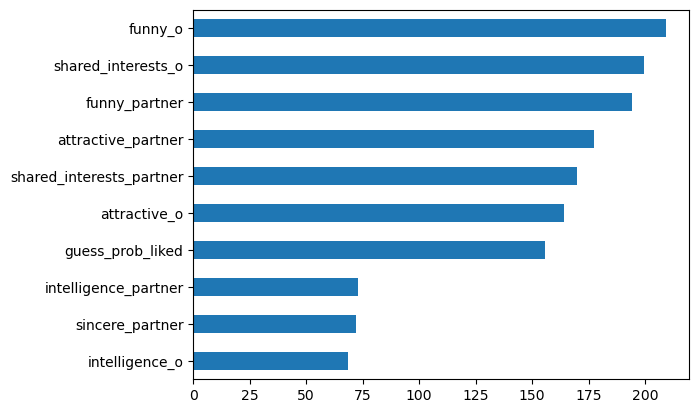

In [233]:
X_train_trans_df2.columns[feature_selector.get_support()]

top_feature_importance_scores = feature_selector.scores_[feature_selector.get_support()]

top_feature_importance_names = X_train_trans_df2.columns[feature_selector.get_support()]

pd.Series(top_feature_importance_scores, index=top_feature_importance_names).sort_values(ascending=True).plot(kind='barh')

## moving forward I'll just use these top 10 features

In [234]:
top10 = top_feature_importance_names.to_list()

In [235]:
#resplit and balance the data using only the top features. still had to use the non-nan data for the models below
top10_plus_match = top10 + ['match']
top10_plus_match

X_train_top10, y_train_top10, X_test_top10, y_test_top10 = split_and_balance(df[top10_plus_match])

In [236]:
X_test_top10.head()

,attractive_o,intelligence_o,funny_o,shared_interests_o,attractive_partner,sincere_partner,intelligence_partner,funny_partner,shared_interests_partner,guess_prob_liked
4701,4.0,7.0,5.0,6.0,5.0,9.0,9.0,9.0,7.0,6.0
3374,5.0,10.0,10.0,10.0,6.0,8.0,8.0,6.0,5.0,5.0
2234,9.0,9.0,3.0,2.0,6.0,8.0,8.0,5.0,3.0,3.0
1166,8.0,8.0,9.0,6.0,7.0,7.0,6.0,7.0,7.0,6.0
598,3.0,4.0,2.0,2.0,5.0,6.0,6.0,7.0,5.0,5.0


## Try ensemble to see which models work the best

In [237]:
from sklearn.naive_bayes import BernoulliNB #choosing Bernoulli since have binary outcome
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#three models that might work well. not using hyperparameters yet
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = BernoulliNB()

#ensemble
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('bnb', clf3)],
    voting='hard')

#find accuracies using cross validated scores
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X_train_top10, y_train_top10, scoring='accuracy', cv=5) #using the split dataset without nans
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.77 (+/- 0.02) [Logistic Regression]
Accuracy: 0.74 (+/- 0.01) [Random Forest]
Accuracy: 0.50 (+/- 0.01) [naive Bayes]
Accuracy: 0.75 (+/- 0.01) [Ensemble]


## Logistic regression did the best here.  
-- Let's look at the top 10 balanced set and all the columns.

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1012
           1       0.35      0.75      0.47       204

    accuracy                           0.72      1216
   macro avg       0.64      0.73      0.64      1216
weighted avg       0.83      0.72      0.75      1216



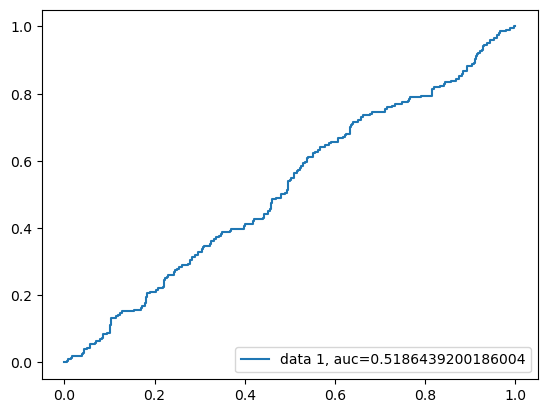

In [315]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

logModel = LogisticRegression(class_weight= 'balanced')
logModel.fit(X_train_top10, y_train_final)
y_pred = logModel.predict(X_test_top10)
print(classification_report(y_test_top10, y_pred))

y_pred_proba = logModel.predict_proba(X_test_top10)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1012
           1       0.41      0.72      0.52       204

    accuracy                           0.78      1216
   macro avg       0.67      0.76      0.69      1216
weighted avg       0.85      0.78      0.80      1216



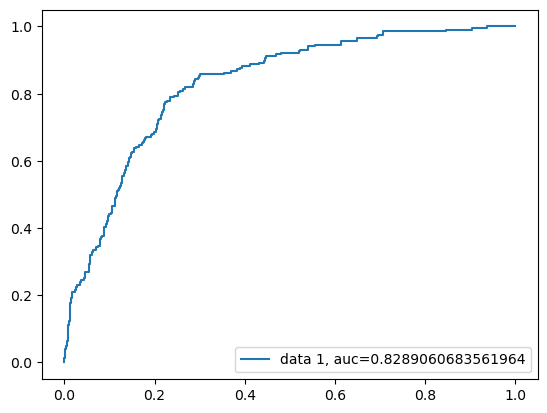

In [316]:
from sklearn.metrics import accuracy_score, classification_report

X_train_trans = transformer.fit_transform(X_train_final)
X_test_trans = transformer.transform(X_test)

logModel = LogisticRegression(class_weight= 'balanced')
logModel.fit(X_train_trans, y_train_final)
predictions_log = logModel.predict(X_test_trans)
print(classification_report(y_test, predictions_log))

y_pred_proba = logModel.predict_proba(X_test_trans)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Precision: Out of all the matches that the model predicted would happen, only 41% actually did.

Recall: Out of all the matches that actually did happen, the model predicted this outcome correctly for 72% of those matches.

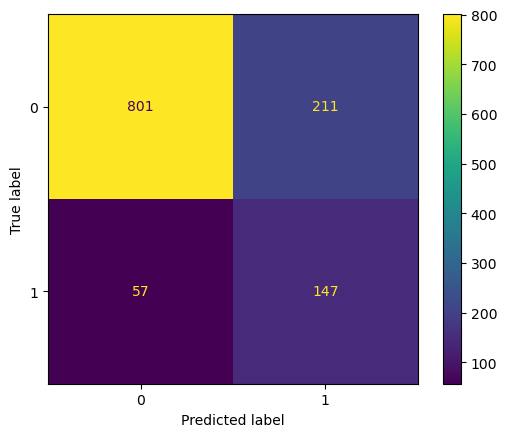

In [247]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, predictions_log)).plot()

# PCA

In [251]:
X_train_final.head()

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_matches,guess_prob_liked,met
4374,female,27.0,28.0,1,asian/pacific islander/asian-american,european/caucasian-american,0,9.0,3.0,biochemistry & molecular biophysics,20.0,20.0,20.0,20.0,0.0,20.0,5.0,7.0,6.0,6.0,6.0,6.0,58.0,5.0,8.0,10.0,7.0,12.0,8.0,9.0,9.0,8.0,8.0,6.0,7.0,7.0,8.0,7.0,6.0,3.0,3.0,6.0,10.0,9.0,9.0,5.0,5.0,8.0,9.0,6.0,9.0,4.0,9.0,9.0,9.0,3.0,0.49,2.0,4.0,5.0,0.0
3943,female,25.0,20.0,5,asian/pacific islander/asian-american,asian/pacific islander/asian-american,1,1.0,1.0,human rights,30.0,10.0,10.0,30.0,10.0,10.0,9.0,10.0,9.0,9.0,8.0,10.0,20.0,10.0,20.0,20.0,10.0,20.0,8.0,8.0,8.0,6.0,6.0,9.0,9.0,7.0,8.0,5.0,8.0,10.0,7.0,7.0,7.0,7.0,7.0,3.0,3.0,4.0,7.0,9.0,7.0,7.0,7.0,8.0,6.0,9.0,0.67,4.0,6.0,8.0,0.0
3890,male,33.0,29.0,4,asian/pacific islander/asian-american,asian/pacific islander/asian-american,1,1.0,5.0,electrical engineering,50.0,5.0,25.0,20.0,0.0,0.0,4.0,9.0,6.0,7.0,8.0,7.0,30.0,30.0,10.0,10.0,0.0,20.0,4.0,9.0,6.0,8.0,2.0,8.0,7.0,7.0,7.0,6.0,5.0,8.0,7.0,5.0,2.0,6.0,6.0,1.0,2.0,7.0,3.0,8.0,5.0,7.0,6.0,9.0,2.0,2.0,-0.44,8.0,3.0,4.0,0.0
963,female,21.0,21.0,0,european/caucasian-american,european/caucasian-american,1,10.0,7.0,psychology,40.0,15.0,10.0,20.0,10.0,5.0,9.0,7.0,6.0,10.0,8.0,7.0,20.0,10.0,30.0,20.0,15.0,5.0,8.0,7.0,8.0,9.0,8.0,9.0,10.0,9.0,8.0,8.0,7.0,2.0,2.0,8.0,7.0,3.0,3.0,1.0,1.0,8.0,10.0,2.0,2.0,6.0,4.0,7.0,8.0,1.0,-0.13,3.0,3.0,8.0,0.0
712,female,22.0,27.0,5,european/caucasian-american,european/caucasian-american,1,1.0,1.0,communications,20.0,15.0,25.0,15.0,20.0,5.0,7.0,7.0,7.0,8.0,7.0,6.0,15.0,20.0,20.0,20.0,5.0,20.0,7.0,9.0,9.0,9.0,4.0,9.0,8.0,7.0,8.0,5.0,7.0,2.0,2.0,1.0,4.0,7.0,7.0,2.0,1.0,6.0,4.0,7.0,5.0,10.0,10.0,10.0,2.0,2.0,0.14,6.0,3.0,5.0,0.0


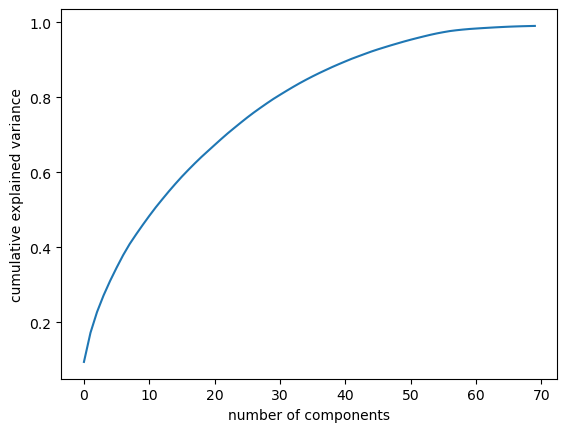

In [304]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = Pipeline([('transformer', transformer),
                         ('pca', PCA(70))]) #first start with most of the features

pca.fit(X_train_final) #pca can't handle nan entries either


pca['pca']

import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [312]:
pca_pipeline = Pipeline([('transformer', transformer),
                         ('scaler', StandardScaler()),
                         ('pca', PCA(60)),
                         ('LR', LogisticRegression())]) #use LR since performed best before - but should we use this one or ensemble?

pca_pipeline.fit(X_train_final, y_train_final)

y_pred = pca_pipeline.predict(X_test)

#sum(y_pred == y_test)/len(y_test)

pca_pipeline.steps[3][1].coef_

array([[-0.22189033,  0.49723573, -0.37856012,  0.17526225,  0.01975486,
        -0.07676309,  0.04914808, -0.03752473, -0.01257279,  0.0268795 ,
        -0.17484536,  0.11989406, -0.17476955, -0.00367288, -0.06293573,
        -0.07200849,  0.10603481,  0.19112189, -0.04475695, -0.01220028,
         0.13210593, -0.19804828, -0.05260971, -0.04779986, -0.04931826,
        -0.02396724,  0.03179686,  0.00233165,  0.15643472,  0.09652262,
        -0.03663521,  0.09629218, -0.09644726, -0.10328141, -0.12211447,
        -0.01637748, -0.03722876, -0.16210302, -0.18025357,  0.1091354 ,
        -0.0889275 , -0.00451241,  0.03934778,  0.02632363, -0.23899274,
        -0.02546472, -0.15617571,  0.05664823,  0.17452099,  0.04423494,
         0.08634549, -0.09686534,  0.20051113,  0.00665083, -0.10415135,
         0.12398059, -0.14693373,  0.06341879, -0.00754962,  0.03541705]])

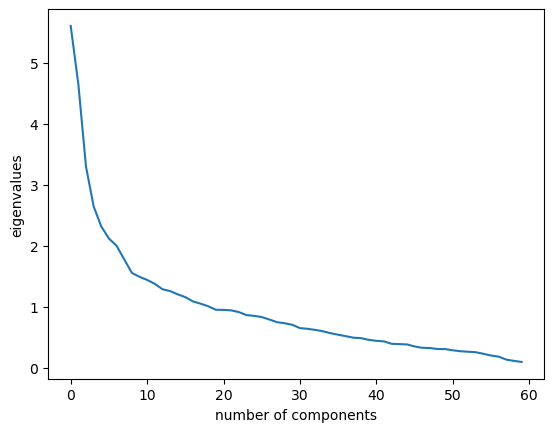

In [275]:
plt.plot(pca.steps[1][1].explained_variance_)
plt.xlabel('number of components')
plt.ylabel('eigenvalues');

In [276]:
print(pca.steps[1][1].explained_variance_)

[5.61040532 4.6549156  3.30143702 2.64810076 2.3169977  2.11775753
 2.00047525 1.77757377 1.5544128  1.48987305 1.4387635  1.37478143
 1.28615128 1.25618054 1.20211738 1.15606317 1.0855262  1.04872588
 1.00586242 0.94829072 0.94707345 0.93871916 0.91068948 0.86090075
 0.84891349 0.82879517 0.78797534 0.74418813 0.72731361 0.70141547
 0.64702044 0.63560997 0.61803549 0.59531196 0.56383421 0.53865218
 0.51462428 0.48994673 0.48237303 0.45412163 0.43835352 0.42889784
 0.38938533 0.38430014 0.37933125 0.34579787 0.32361536 0.31980761
 0.30404735 0.30277539 0.28313825 0.26746231 0.25925223 0.25099666
 0.2254433  0.19700758 0.17874124 0.12991939 0.10878689 0.09191152]


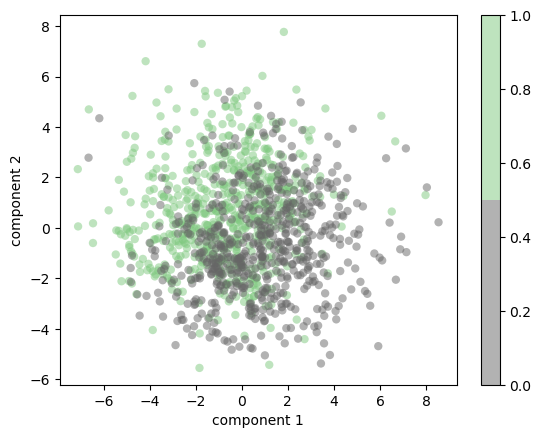

In [259]:
pca2 = Pipeline([('transformer', transformer),
                         ('pca', PCA(2))]) #project to 2 dimensions
projected = pca2.fit_transform(X_train_final)

plt.scatter(projected[:, 0], projected[:, 1],
            c=y_train_final, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent_r', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

KMeans

In [295]:
from sklearn.preprocessing import LabelEncoder

df_kmeans = X_train_final.copy()

number = LabelEncoder()
df_kmeans["gender"] = number.fit_transform(df_kmeans["gender"].astype('str'))
df_kmeans["race"] = number.fit_transform(df_kmeans["race"].astype('str'))
df_kmeans["race_o"] = number.fit_transform(df_kmeans["race_o"].astype('str'))
df_kmeans["field"] = number.fit_transform(df_kmeans["field"].astype('str'))





In [296]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
onehot_fit_trans = SS.fit_transform(df_kmeans)


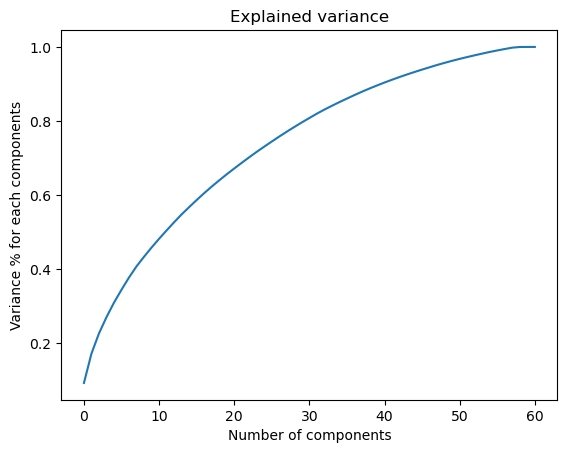

In [297]:
pca=PCA().fit(onehot_fit_trans)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance % for each components')
plt.title('Explained variance')
plt.show()

In [298]:
pca=PCA(n_components=2)
pca.fit(onehot_fit_trans)
x_pca=pca.transform(onehot_fit_trans)
x_pca

array([[-0.63911337, -1.51210132],
       [-1.8059587 ,  1.88627858],
       [ 3.63013905,  0.92448854],
       ...,
       [-1.15319678,  1.52981347],
       [ 4.39433576,  0.89496783],
       [ 3.12559495,  1.53775138]])

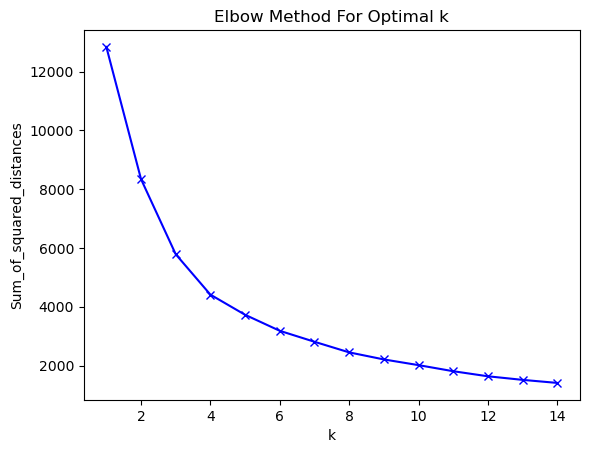

In [299]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(x_pca)
    Sum_of_squared_distances.append(km.inertia_)
#Visualing the plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

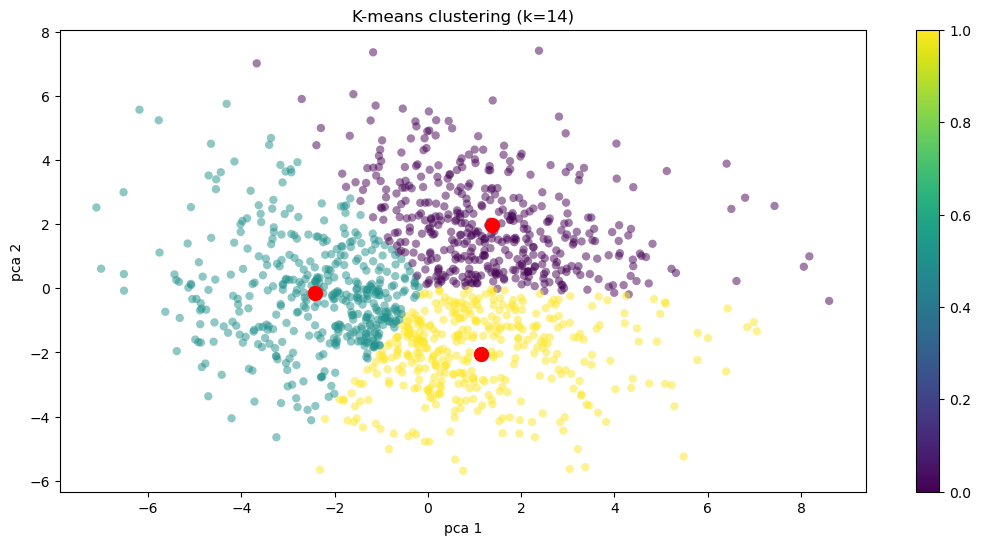

In [302]:
# Fit and plot the data for each k value
#for k in k_range:
kmeans = KMeans(n_clusters=3, \
                init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(x_pca)
plt.figure(figsize=(13,6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_kmeans, edgecolor='none', alpha=0.5, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0],\
            kmeans.cluster_centers_[:, 1], \
            s=100, c='red')
plt.title('K-means clustering (k={})'.format(k))
plt.xlabel('pca 1')
plt.ylabel('pca 2')
plt.colorbar()
plt.show()